# Homework 1

## Check installazione spark

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark import SparkConf
from pyspark.context import SparkContext

conf = (
    SparkConf()
      # Configurazione per abilitare il Security Manager e risolvere i problemi legati a Java
      .set("spark.driver.extraJavaOptions",   "-Djava.security.manager=allow")
)

sc = SparkContext.getOrCreate(conf=conf)

print("Java:", sc._jvm.System.getProperty("java.version"))
print("Spark:", sc.version)

assert  "3." in sc.version, "Verify that the cluster Spark's version is 3.x"


Java: 21.0.6
Spark: 3.5.5


In [3]:
print("Spark version:", sc.version)

Spark version: 3.5.5


In [4]:
from pyspark.sql import SparkSession
spark_session = SparkSession(sc)

## Lettura Dataset

Il blocco di codice successivo serve a:
1. Usare la prima riga automaticamente come header  
2. Fare inferenza automatica sul tipo di dato di ogni colonna  
3. Gestire records multi-linea  
4. Specificare che sono usate le doppie virgolette per racchiudere i campi  
5. Gestire le virgolette all'interno dei campi racchiusi dalle stesse  
6. Permettere il parsing di record non formattati perfettamente senza fallire  
7. Specificare il path del file `.csv` da cui leggere  

In [5]:
# Load the CSV file into a DataFrame
df_clinical = spark_session.read \
  .option("header", "true") \
  .option("inferSchema", "true") \
  .option("multiLine", "true") \
  .option("quote", '"') \
  .option("escape", '"') \
  .option("mode", "PERMISSIVE") \
  .csv('dimensions_clinicalTrials.csv') 

In [6]:
df_clinical.printSchema()  # Prints the schema of the DataFrame

root
 |-- Rank: integer (nullable = true)
 |-- Trial ID: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Brief title: string (nullable = true)
 |-- Acronym: string (nullable = true)
 |-- Abstract: string (nullable = true)
 |-- Start date: date (nullable = true)
 |-- Start Year: double (nullable = true)
 |-- End Date: date (nullable = true)
 |-- Completion Year: double (nullable = true)
 |-- Phase: string (nullable = true)
 |-- Study Type: string (nullable = true)
 |-- Study Design: string (nullable = true)
 |-- Conditions: string (nullable = true)
 |-- Recruitment Status: string (nullable = true)
 |-- Number of Participants: double (nullable = true)
 |-- Intervention: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Registry: string (nullable = true)
 |-- Investigators/Contacts: string (nullable = true)
 |-- Sponsors/Collaborators: string (nullable = true)
 |-- City of Sponsor/Collaborator: string (nullable = true

In [7]:
df_clinical.show(5)  # Displays the first 5 rows of the DataFrame

+----+--------------+--------------------+--------------------+-----------------+--------------------+----------+----------+----------+---------------+-------+--------------+--------------------+--------------------+------------------+----------------------+--------------------+------+-------------------+------------------+----------------------+----------------------+----------------------------+-----------------------------+-------------------------------+---------------------+------------+--------------+--------------------+-------------------------+--------------------+--------------------------------+--------------------+--------------------+-------------------+------------+--------------+---------------+
|Rank|      Trial ID|               Title|         Brief title|          Acronym|            Abstract|Start date|Start Year|  End Date|Completion Year|  Phase|    Study Type|        Study Design|          Conditions|Recruitment Status|Number of Participants|        Intervention|G

## Analytics di esempio

Numero di studi cominciati per anno

In [8]:
df_clinical.filter(df_clinical["Start Year"].isNotNull()) \
    .groupBy("Start Year") \
    .count() \
    .orderBy("count", ascending = False) \
    .show(10)  # Displays the count of clinical trials by start year

+----------+-----+
|Start Year|count|
+----------+-----+
|    2021.0| 1460|
|    2020.0| 1438|
|    2019.0| 1321|
|    2018.0| 1207|
|    2022.0| 1151|
|    2017.0| 1146|
|    2016.0|  850|
|    2015.0|  841|
|    2013.0|  784|
|    2014.0|  767|
+----------+-----+
only showing top 10 rows



Numero medio di partecipanti per tipo di studio

In [9]:
from pyspark.sql.functions import avg, round

df_clinical.filter(df_clinical["Number of Participants"].isNotNull()) \
    .groupBy("Study Type") \
    .agg(round(avg("Number of Participants"), 2).alias("avg_participants")) \
    .orderBy("avg_participants", ascending = False) \
    .show(10)  # Displays the average number (roundend to the .2 decimal) of participants by study type

+-------------------+----------------+
|         Study Type|avg_participants|
+-------------------+----------------+
|Active surveillance|        115000.0|
| Non-interventional|          3260.8|
|      Observational|         2632.76|
|     Interventional|          660.18|
|                CCT|           520.0|
|              Other|           202.0|
+-------------------+----------------+



Top 10 medical conditions più presenti

In [10]:
df_clinical.filter(df_clinical["Conditions"].isNotNull()) \
    .groupBy("Conditions") \
    .count() \
    .orderBy("count", ascending = False) \
    .show(10)  # Displays the top 10 count of clinical trials by condition

+--------------------+-----+
|          Conditions|count|
+--------------------+-----+
|       Breast Cancer|  281|
|    Multiple Myeloma|  179|
|      Ovarian Cancer|  126|
|            Melanoma|  118|
|  Ulcerative Colitis|  112|
|Acute Myeloid Leu...|  106|
|            Leukemia|  102|
|Carcinoma, Non-Sm...|  101|
| Follicular Lymphoma|   92|
|Metastatic Colore...|   90|
+--------------------+-----+
only showing top 10 rows



Paesi con il numero più alto di partecipanti

In [11]:
df_clinical.filter(df_clinical["Number of Participants"].isNotNull() & df_clinical["Funder Country"].isNotNull()) \
    .groupBy("Funder Country") \
    .count() \
    .orderBy("count", ascending = False) \
    .show(10)  # Displays the top 10 count of clinical trials by funder country

+--------------------+-----+
|      Funder Country|count|
+--------------------+-----+
|       United States| 2785|
|               Italy| 1797|
|             Germany|  391|
|               Japan|  325|
|             Belgium|  240|
|        Italy; Italy|  182|
|         Switzerland|  165|
|United States; Un...|  107|
|      United Kingdom|   91|
|United States; Japan|   68|
+--------------------+-----+
only showing top 10 rows



Si può notare che esistono anche duplicati o paesi che hanno probabilmente una collaborazione (separati da ;) che sono presenti in conteggi separati. Pertanto è utile provare a separarli.

In [12]:
from pyspark.sql.functions import split, explode, trim

# Split the 'Funder Country' column by ';' and explode it into separate rows
df_cleaned = df_clinical.withColumn("Funder Country", explode(split(df_clinical["Funder Country"], ";")))

# Remove leading/trailing whitespace from country names
df_cleaned = df_cleaned.withColumn("Funder Country", trim(df_cleaned["Funder Country"]))

# Filter out null values and group by 'Funder Country'
df_cleaned.filter(df_cleaned["Number of Participants"].isNotNull() & df_cleaned["Funder Country"].isNotNull()) \
    .groupBy("Funder Country") \
    .count() \
    .orderBy("count", ascending=False) \
    .show(10)  # Displays the top 10 count of clinical trials by funder country

+--------------+-----+
|Funder Country|count|
+--------------+-----+
| United States| 3662|
|         Italy| 2939|
|       Germany|  602|
|         Japan|  547|
|United Kingdom|  408|
|       Belgium|  347|
|   Switzerland|  278|
|   Netherlands|  197|
|        France|  150|
|       Denmark|   82|
+--------------+-----+
only showing top 10 rows



## Analytics proposte

### Distribuzione delle Age Groups in base alle condizioni

In [13]:
#Si sono filtrati i dati per età e condizioni, e sono stati esclusi i valori nulli e le righe con "None - None" o "N/A - N/A"
df_clinical.filter(df_clinical["Age"].isNotNull() & df_clinical["Conditions"].isNotNull() & (df_clinical["Age"] != "None - None") & (df_clinical["Age"] != "N/A - N/A")) \
    .groupBy("Age", "Conditions") \
    .count() \
    .orderBy("count", ascending = False) \
    .show(10) 

+--------------+--------------------+-----+
|           Age|          Conditions|count|
+--------------+--------------------+-----+
|18 Years - N/A|       Breast Cancer|  212|
|18 Years - N/A|    Multiple Myeloma|  159|
|18 Years - N/A|      Ovarian Cancer|   99|
|18 Years - N/A|Carcinoma, Non-Sm...|   97|
|18 Years - N/A|Non-Small Cell Lu...|   78|
|18 Years - N/A|Metastatic Breast...|   77|
|18 Years - N/A| Follicular Lymphoma|   69|
|18 Years - N/A|       Heart Failure|   66|
|18 Years - N/A|            Melanoma|   66|
|18 Years - N/A|Chronic Myeloid L...|   64|
+--------------+--------------------+-----+
only showing top 10 rows



In [14]:
#Qui si è sceso nel particolare delle top 3 Condizioni, per vedere le età più comuni per ciascuna di esse
df_clinical.filter(df_clinical["Age"].isNotNull() & (df_clinical["Conditions"] == "Breast Cancer") & (df_clinical["Age"] != "None - None") & (df_clinical["Age"] != "N/A - N/A") ) \
    .groupBy("Age", "Conditions") \
    .count() \
    .orderBy("count", ascending = False) \
    .show(5) 

df_clinical.filter(df_clinical["Age"].isNotNull() & (df_clinical["Conditions"] == "Multiple Myeloma") & (df_clinical["Age"] != "None - None") & (df_clinical["Age"] != "N/A - N/A") ) \
    .groupBy("Age", "Conditions") \
    .count() \
    .orderBy("count", ascending = False) \
    .show(5) 

df_clinical.filter(df_clinical["Age"].isNotNull() & (df_clinical["Conditions"] == "Ovarian Cancer") & (df_clinical["Age"] != "None - None") & (df_clinical["Age"] != "N/A - N/A") ) \
    .groupBy("Age", "Conditions") \
    .count() \
    .orderBy("count", ascending = False) \
    .show(5) 

+-------------------+-------------+-----+
|                Age|   Conditions|count|
+-------------------+-------------+-----+
|     18 Years - N/A|Breast Cancer|  212|
|18 Years - 70 Years|Breast Cancer|    8|
|18 Years - 75 Years|Breast Cancer|    7|
|     N/A - 70 Years|Breast Cancer|    4|
|18 Years - 45 Years|Breast Cancer|    4|
+-------------------+-------------+-----+
only showing top 5 rows

+-------------------+----------------+-----+
|                Age|      Conditions|count|
+-------------------+----------------+-----+
|     18 Years - N/A|Multiple Myeloma|  159|
|18 Years - 65 Years|Multiple Myeloma|    8|
|18 Years - 70 Years|Multiple Myeloma|    5|
|     65 Years - N/A|Multiple Myeloma|    2|
|18 Years - 80 Years|Multiple Myeloma|    1|
+-------------------+----------------+-----+

+-------------------+--------------+-----+
|                Age|    Conditions|count|
+-------------------+--------------+-----+
|     18 Years - N/A|Ovarian Cancer|   99|
|18 Years - 75 Year

Partendo dai risultati precedenti, si è proceduto ad estrarre la Start Age dell'Age Group per raggruppare il campione su tale base.

In [15]:
from pyspark.sql.functions import split

df_clinical_with_start_age = df_clinical.withColumn("Start Age", split(df_clinical["Age"], " ")[0])

df_clinical_with_start_age.filter(
    df_clinical_with_start_age["Age"].isNotNull() & 
    (df_clinical_with_start_age["Conditions"] == "Breast Cancer") & 
    (df_clinical_with_start_age["Age"] != "None - None") & 
    (df_clinical_with_start_age["Age"] != "N/A - N/A")
) \
    .groupBy("Start Age", "Conditions") \
    .count() \
    .orderBy("count", ascending=False) \
    .show(5)

df_clinical_with_start_age.filter(
    df_clinical_with_start_age["Age"].isNotNull()& 
    (df_clinical_with_start_age["Conditions"] == "Multiple Myeloma") & 
    (df_clinical_with_start_age["Age"] != "None - None") & 
    (df_clinical_with_start_age["Age"] != "N/A - N/A")
) \
    .groupBy("Start Age", "Conditions") \
    .count() \
    .orderBy("count", ascending=False) \
    .show(5)

df_clinical_with_start_age.filter(
    df_clinical_with_start_age["Age"].isNotNull() & 
    (df_clinical_with_start_age["Conditions"] == "Ovarian Cancer") & 
    (df_clinical_with_start_age["Age"] != "None - None") & 
    (df_clinical_with_start_age["Age"] != "N/A - N/A")
) \
    .groupBy("Start Age", "Conditions") \
    .count() \
    .orderBy("count", ascending=False) \
    .show(5)

+---------+-------------+-----+
|Start Age|   Conditions|count|
+---------+-------------+-----+
|       18|Breast Cancer|  246|
|       65|Breast Cancer|    6|
|       45|Breast Cancer|    6|
|      N/A|Breast Cancer|    5|
|       40|Breast Cancer|    4|
+---------+-------------+-----+
only showing top 5 rows

+---------+----------------+-----+
|Start Age|      Conditions|count|
+---------+----------------+-----+
|       18|Multiple Myeloma|  173|
|       65|Multiple Myeloma|    2|
+---------+----------------+-----+

+---------+--------------+-----+
|Start Age|    Conditions|count|
+---------+--------------+-----+
|       18|Ovarian Cancer|  111|
|      N/A|Ovarian Cancer|    7|
|       70|Ovarian Cancer|    2|
+---------+--------------+-----+



### Anomaly Detection Analysis

In questo caso si è cercato di fare una anomaly detection basandosi sul numero di partecipanti ad ogni trial. Usando il metodo IQR (Inter-Quartile Range) si identificano i Trial che hanno un alto o un basso numero di partecipanti con la stessa condizione.

In [16]:
from pyspark.sql.functions import col, expr, percentile_approx, first

# Calculate Q1, Q3, and IQR for each condition
iqr_stats = df_clinical.filter(df_clinical["Number of Participants"].isNotNull()) \
    .groupBy("Conditions") \
    .agg(
        percentile_approx("Number of Participants", 0.25).alias("Q1"),
        percentile_approx("Number of Participants", 0.75).alias("Q3")
    ) \
    .withColumn("IQR", col("Q3") - col("Q1")) \
    .withColumn("Lower_Bound", col("Q1") - 1.5 * col("IQR")) \
    .withColumn("Upper_Bound", col("Q3") + 1.5 * col("IQR"))

# Join the IQR stats back to the original DataFrame
df_with_iqr = df_clinical.filter(df_clinical["Number of Participants"].isNotNull()) \
    .join(iqr_stats, on="Conditions", how="inner")

# Flag anomalies based on IQR
anomalies = df_with_iqr.filter(
    (col("Number of Participants") < col("Lower_Bound")) |
    (col("Number of Participants") > col("Upper_Bound"))
)

# Select records within the bounds
valid_records = df_with_iqr.filter(
    (col("Number of Participants") >= col("Lower_Bound")) &
    (col("Number of Participants") <= col("Upper_Bound"))
)

# Group by Conditions and select the first anomaly for each condition
unique_anomalies = anomalies.groupBy("Conditions").agg(
    first("Number of Participants").alias("Number of Participants"),
    first("Lower_Bound").alias("Lower_Bound"),
    first("Upper_Bound").alias("Upper_Bound"),
    first("Trial ID").alias("Trial ID")
)

# Show unique anomalies with full-length Conditions column
print("Anomalies:")
unique_anomalies.show(10,truncate=False)

# Show valid records with study information
print("Valid Records:")
valid_records.select("Conditions", "Number of Participants", "Lower_Bound", "Upper_Bound", "Trial ID").show(10,truncate=False)

Anomalies:
+----------------------------------+----------------------+-----------+-----------+-----------+
|Conditions                        |Number of Participants|Lower_Bound|Upper_Bound|Trial ID   |
+----------------------------------+----------------------+-----------+-----------+-----------+
|AL Amyloidosis                    |5000.0                |-20.0      |140.0      |NCT04839003|
|AML                               |246.0                 |367.0      |367.0      |NCT02152956|
|ARDS                              |740.0                 |-110.0     |226.0      |NCT03963622|
|Acute Coronary Syndromes          |10000.0               |2597.0     |2597.0     |NCT02438085|
|Acute Leukemia                    |40.0                  |101.0      |101.0      |NCT01385891|
|Acute Lymphoblastic Leukemia      |280.0                 |-70.0      |210.0      |NCT00358072|
|Acute Myelogenous Leukemia        |326.0                 |561.0      |593.0      |NCT00317642|
|Acute Promyelocytic Leukemia

### Correlation Analysis tra Visibilità Mediatica e Durata/Partecipanti

In [19]:
from pyspark.sql.functions import col, to_date, datediff
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

df_corr = df_clinical \
    .filter(
        col("Altmetric Attention Score").isNotNull() &
        col("Number of Participants").isNotNull() &
        col("Start date").isNotNull() &
        col("End Date").isNotNull()
    ) \
    .withColumn("StartDate", to_date(col("Start date"), "yyyy-MM-dd")) \
    .withColumn("EndDate",   to_date(col("End Date"),   "yyyy-MM-dd")) \
    .withColumn("DurationDays", datediff(col("EndDate"), col("StartDate")))

# Correlazione attraverso Pearson e Spearman
pdf = df_corr.select(
    "Altmetric Attention Score",
    "Number of Participants",
    "DurationDays"
).toPandas()

from scipy.stats import pearsonr, spearmanr, kendalltau

def interpret_results(name, pearson_r, p_pearson, spearman_rho, p_spearman, kendall_tau, p_kendall):
    print(f"[Altmetric vs {name}]")

    print(f"  Pearson r = {pearson_r:.3f}, p = {p_pearson:.3e}")
    if p_pearson < 0.05:
        print("    → Esiste una correlazione lineare statisticamente significativa.")
    else:
        print("    → Nessuna evidenza di correlazione lineare significativa.")

    print(f"  Spearman ρ = {spearman_rho:.3f}, p = {p_spearman:.3e}")
    if p_spearman < 0.05:
        print("    → Esiste una correlazione monotona significativa, anche se non necessariamente lineare.")
    else:
        print("    → Nessuna evidenza di correlazione monotona significativa.")

    print(f"  Kendall τ = {kendall_tau:.3f}, p = {p_kendall:.3e}")
    if p_kendall < 0.05:
        print("    → Le variabili mostrano concordanza significativa tra le coppie di osservazioni.")
    else:
        print("    → Nessuna evidenza di concordanza significativa tra le variabili.")
    print()

# Calcolo per Number of Participants
pearson_np, p_np = pearsonr(pdf["Altmetric Attention Score"], pdf["Number of Participants"])
spearman_np, sp_p_np = spearmanr(pdf["Altmetric Attention Score"], pdf["Number of Participants"])
kendall_np, k_p_np = kendalltau(pdf["Altmetric Attention Score"], pdf["Number of Participants"])

# Calcolo per DurationDays
pearson_dur, p_dur = pearsonr(pdf["Altmetric Attention Score"], pdf["DurationDays"])
spearman_dur, sp_p_dur = spearmanr(pdf["Altmetric Attention Score"], pdf["DurationDays"])
kendall_dur, k_p_dur = kendalltau(pdf["Altmetric Attention Score"], pdf["DurationDays"])

# Interpretazione
interpret_results("Number of Participants", pearson_np, p_np, spearman_np, sp_p_np, kendall_np, k_p_np)
interpret_results("DurationDays", pearson_dur, p_dur, spearman_dur, sp_p_dur, kendall_dur, k_p_dur)

[Altmetric vs Number of Participants]
  Pearson r = 0.005, p = 6.786e-01
    → Nessuna evidenza di correlazione lineare significativa.
  Spearman ρ = 0.274, p = 8.738e-112
    → Esiste una correlazione monotona significativa, anche se non necessariamente lineare.
  Kendall τ = 0.189, p = 2.883e-108
    → Le variabili mostrano concordanza significativa tra le coppie di osservazioni.

[Altmetric vs DurationDays]
  Pearson r = 0.004, p = 7.711e-01
    → Nessuna evidenza di correlazione lineare significativa.
  Spearman ρ = 0.125, p = 9.215e-24
    → Esiste una correlazione monotona significativa, anche se non necessariamente lineare.
  Kendall τ = 0.084, p = 3.881e-23
    → Le variabili mostrano concordanza significativa tra le coppie di osservazioni.



Nonostante il numero di partecipanti non sia linearmente legato alla popolarità mediatica di uno studio, esiste un pattern per cui gli studi con più partecipanti tendono ad avere un Altmetric Score più alto. Questo pattern suggerisce che la dimensione del trial è associata a una maggiore attenzione mediatica, ma non è l’unico fattore determinante. 

Anche se esiste una debole correlazione monotona tra la durata dello studio e l'Altmetric Score, l'effetto appare marginale (ρ e τ molto bassi). Non si tratta di una relazione lineare, ma piuttosto di una tendenza in cui studi più lunghi tendono ad avere un Altmetric Score leggermente più alto. 

### Analisi della durata dei trial clinici per fase

+--------------------+----+
|               Phase| cnt|
+--------------------+----+
|             Phase 1| 259|
|           Phase 1/2| 376|
|             Phase 2|2955|
|           Phase 2/3| 351|
|             Phase 3|4934|
|           Phase 3/4|   3|
|             Phase 4| 602|
|Post Authorisatio...|  22|
+--------------------+----+



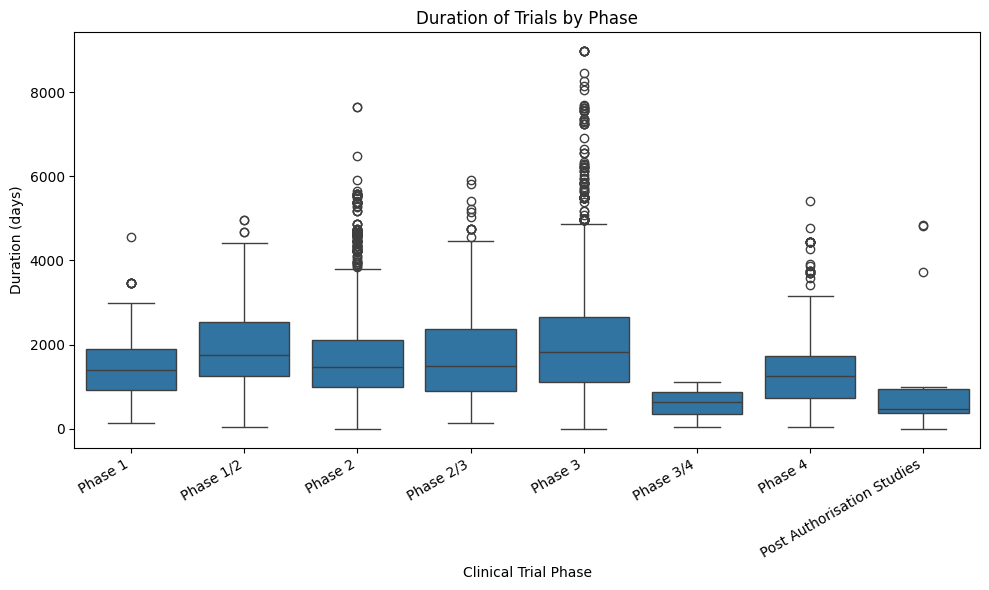

ANOVA one-way across phases: F = 47.002, p = 5.690e-66
→ Differenze di durata significative fra almeno due fasi.


In [20]:
from pyspark.sql.functions import col, to_date, datediff, count, mean, expr
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns

# Filtraggio per escludere date nulle e calcolo della durata in giorni
df_dur = (
    df_clinical
    .filter(
        col("Phase").isNotNull() &
        col("Start date").isNotNull() &
        col("End Date").isNotNull()
    )
    .withColumn("StartDate", to_date(col("Start date"), "yyyy-MM-dd"))
    .withColumn("EndDate",   to_date(col("End Date"),   "yyyy-MM-dd"))
    .withColumn("DurationDays", datediff(col("EndDate"), col("StartDate")))
    .select("Phase", "DurationDays")
)

# Conteggio delle fasi presenti nel dataset
df_dur.groupBy("Phase").agg(count("*").alias("cnt")).orderBy(expr("Phase")).show()

# Ordine delle fasi
desired_order = [
    "Phase 1", "Phase 1/2",
    "Phase 2", "Phase 2/3",
    "Phase 3", "Phase 3/4",
    "Phase 4", "Post Authorisation Studies"
]
phases_present = [ph for ph in desired_order
                  if ph in [row.Phase for row in df_dur.select("Phase").distinct().collect()]]


pdf_dur = df_dur.toPandas()

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="Phase",
    y="DurationDays",
    data=pdf_dur,
    order=phases_present
)
plt.title("Duration of Trials by Phase")
plt.xlabel("Clinical Trial Phase")
plt.ylabel("Duration (days)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# ANOVA
groups = [g["DurationDays"].values for _, g in pdf_dur.groupby("Phase")]
f_stat, p_val = f_oneway(*groups)
print(f"ANOVA one-way across phases: F = {f_stat:.3f}, p = {p_val:.3e}")
if p_val < 0.05:
    print("→ Differenze di durata significative fra almeno due fasi.")
else:
    print("→ Nessuna differenza significativa di durata fra le fasi.")

Le fasi cliniche mostrano differenze significative nella durata degli studi, con fasi come Phase 1 e Phase 4 che tendono a durare meno rispetto a Phase 2 e Phase 3, le quali mostrano una maggiore variabilità.

## Analisi geografica e multicentricità

I trial sponsorizzati in più di un Paese tendono ad avere più partecipanti rispetto a quelli locali?

L'analisi confronta il numero di partecipanti tra i trial sponsorizzati in un solo Paese e quelli multinazionali. Prima si categorizzano gli studi in base al numero di Paesi coinvolti, separando i dati relativi ai trial nazionali da quelli multinazionali. Poi si confrontano le medie dei partecipanti tra i due gruppi utilizzando un test statistico (test T di Welch). Se il test rileva una differenza significativa tra le medie, si conclude che i trial multinazionali tendono ad avere più partecipanti.

In [ ]:
from pyspark.sql.functions import split, size, when, trim, col, array_distinct, expr, array

# Toglie eventuali spazi all'inizio/fine del campo con i Paesi
df_clinical = df_clinical.withColumn(
    "Country_Clean",
    trim(col("Country of Sponsor/Collaborator"))
)

# Separa i Paesi usando il punto e virgola (;) come separatore
df_clinical = df_clinical.withColumn(
    "Country_List",
    split(col("Country_Clean"), ";")
)

# Rimuove gli spazi vuoti e gli elementi vuoti nell'array
df_clinical = df_clinical.withColumn(
    "Country_List",
    array_distinct(
        expr("array_distinct(transform(Country_List, x -> trim(x)))")
    )
)

# Filtria per rimuovere gli eventuali Paesi vuoti (stringhe vuote) nell'array
df_clinical = df_clinical.withColumn(
    "Country_List",
    expr("filter(Country_List, x -> x != '')")  # Rimuove gli elementi vuoti dall'array
)

# Determina se lo studio è multinazionale
df_clinical = df_clinical.withColumn(
    "is_multinational",
    when(size(col("Country_List")) > 1, 1).otherwise(0)
)

# Seleziona solo le colonne rilevanti e filtra i valori validi
df_filtered = df_clinical.filter(
    df_clinical["Number of Participants"].isNotNull()
).select(
    "Number of Participants", 
    "is_multinational", 
    "Country_List"  # Mostriamo anche i Paesi
)

# Mostra i 10 studi con più partecipanti, inclusa la lista dei Paesi
df_filtered.orderBy("Number of Participants", ascending=False).show(10, truncate=80)


+----------------------+----------------+--------------------------------------------------------------------------------+
|Number of Participants|is_multinational|                                                                    Country_List|
+----------------------+----------------+--------------------------------------------------------------------------------+
|             2400000.0|               1|[United Kingdom, Austria, France, Germany, Hungary, Iceland, Ireland, Italy, ...|
|             1000000.0|               1|           [Netherlands, Italy, Spain, Germany, France, United Kingdom, Denmark]|
|              285600.0|               1|                                                          [Italy, United States]|
|              285600.0|               1|                                                          [Italy, United States]|
|              120000.0|               1|[United States, Argentina, Austria, Belgium, Brazil, China, Colombia, Czechia...|
|              1

In [48]:
from pyspark.sql.functions import avg, count
from scipy.stats import ttest_ind
import numpy as np

# Statistiche sui trial nazionali
stats_national = df_filtered.filter("is_multinational = 0") \
    .selectExpr("`Number of Participants` as participants") \
    .agg(
        count("participants").alias("n_count"),
        avg("participants").alias("n_avg")
    ).collect()[0]

# Statistiche sui trial multinazionali
stats_multinational = df_filtered.filter("is_multinational = 1") \
    .selectExpr("`Number of Participants` as participants") \
    .agg(
        count("participants").alias("m_count"),
        avg("participants").alias("m_avg")
    ).collect()[0]

# Per il test statistico, estrai i dati in formato lista
group_national = df_filtered.filter("is_multinational = 0") \
    .select("Number of Participants") \
    .rdd.flatMap(lambda x: x).collect()

group_multinational = df_filtered.filter("is_multinational = 1") \
    .select("Number of Participants") \
    .rdd.flatMap(lambda x: x).collect()

# T-test di Welch
t_stat, p_value = ttest_ind(group_national, group_multinational, equal_var=False)

# Stampa dei risultati
print(f"Osservazioni nazionali: {stats_national['n_count']}")
print(f"Osservazioni multinazionali: {stats_multinational['m_count']}")
print(f"Media (nazionali): {stats_national['n_avg']:.2f}")
print(f"Media (multinazionali): {stats_multinational['m_avg']:.2f}")
print("\n")
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Differenza significativa tra trial nazionali e multinazionali")
else:
    print("Nessuna differenza significativa")


Osservazioni nazionali: 4763
Osservazioni multinazionali: 10072
Media (nazionali): 674.19
Media (multinazionali): 1361.59


T-statistic: -2.567
P-value: 0.0103
Differenza significativa tra trial nazionali e multinazionali
